##  Unsupervised Learning Series

# 9.3  K-means clustering

We have just seen how Principal Component Analysis can be used as a basis for various normalization schemes, as well as a tool for simplifying a high dimensional dataset by properly reducing its *input* or *feature* dimension.  The subject of this Section is another tool for simplifying data, however here the problem is not (necessarily) that the data lives in high dimension but that there are simply too many datapoints to process (either by an algorithm or a human interpreter).  The focus of this Section - the *K-means algorithm* - is an elemenatry example of another set of unsupervised learning methods called *clustering algorithms*.  These algorithms are designed to (properly) reduce the number of points in a dataset, which we refer to as the *data dimension* of a dataset, and in doing so help us understand the structure of our data.

In [80]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib inline

from sklearn import datasets
from IPython import display
from mlrefined_libraries import unsupervised_library as unsuperlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 9.3.1  Representing a dataset via clusters

One very simple way to simplify a dataset is by grouping together nearby points into *clusters*.  Take the following set of two-dimensional data points, shown in the left panel below.  When you look at the image of this data you can see that it naturally falls into three groups or *clusters*, because you have something along the lines of a clustering algorithms 'built in' to your mental software (along with many other pattern recognition abilities).  

In the right panel we project a visual representation of each cluster onto the data, including each cluster's boundary drawn as a uniquely colored dahsed curve.  We also draw the center of each cluster using an $\times$ symbol that matches the unique boundary color of each cluster.  These cluster centers are often referred to in the jargon of machine learning as cluster *centroids*.  The centroids here allow us to think about the dataset in the big picture sense - instead of $P = 10$ points we can think of our dataset grossly in terms of these $K=3$ cluster centroids, as each represents a chunk of the data.  

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_2.png' width="75%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> ADJUST FIGURE? - these look like the colors we are using for classification labeled data, I think we should use different colors here to make sure there is no confusion between classification / clustering (left) A 2-dimensional toy dataset with $P=10$ data points. (right) The data shown naturally clustered into $K=3$ clusters.  Points that are geometrically close to one another belong to the same cluster, and each cluster boundary is roughly marked using a uniquely colored dashed curve.  Each cluster center - also called a *centroid* - is marked by a $\times$ symboled colored to match its cluster boundary.</em>  </figcaption> 
</figure>

How can we describe - mathematically speaking - the clustering scenario we naturally see when we view the points in the left panel above, as highlighted in the right panel?  

First some notation.  As in the prevoious Sections we will denote our set of $P$ points generically as $\mathbf{x}_1,\,\mathbf{x}_2,\,...,\mathbf{x}_P$ where in our current instance $P=10)$ all of dimension $N$ (in our example here $N=2$).  To keep things as generally applicable as possible we will also use the notation $K$ to denote the number of clusters in a dataset, in our current example $K=3$.  Because each cluster has a centroid we need notation for this as well, and we will use $\mathbf{c}_1,\,\mathbf{c}_2,\,...,\mathbf{c}_K$ to denote these where $\mathbf{c}_k$ is the centroid of the $k^{th}$ cluster.  Finally we need a notation to denote the set of points that belong to each cluster.  We denote the set of indies of those points belonging to the $k^{th}$ cluster as

\begin{equation}
\mathcal{S}_k =  \left\{ p\,\, \lvert \,\,\text{if $\mathbf{x}_p$ belongs to the $k^{th}$ cluster } \right\}.
\end{equation}

Finally we need a notation to denote the centroid of each cluster - we will denote by $\mathbf{c}_k$ the centroid of the $k^{th}$ cluster. 

With all of our notation in hand we can now better describe the prototype clusteriing scenario shown in the figure above.  Again, note here we have assumed that we have identified each cluster and its centroid 'bye eye'.  Firstly, because the centroid denotes the center of a cluster it seems intuitive that each one should be expressable as the average of the points assigned to each cluster.  Algebraically this is to say that

\begin{equation}
\mathbf{c}_k = \frac{1}{\left\vert\mathcal{S}_k\right\vert}\sum_{p\in\mathcal{S}_k}\mathbf{x}_p.
\end{equation}

This formula confirms the intuition that each centroid represents a chunk of the data - the average of those points belonging to each cluster.  

Next we can state mathematically an obvious and implicit fact about the clustering scenario above: that each point belongs to the cluster whose centroid it is closest too. To express this algebraically for a given point $\mathbf{x}_p$ is simply say that the point must belong to the cluster where the distance to the centroid $\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2$ is minimal.  In other words, the point $\mathbf{x}_p$ belongs to or is *assigned* to cluster $k^{\star}$ if

\begin{equation}
a_p = \underset{k=1,...,K}{\text{argmin}} \,\,\,\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2
\end{equation}

In the jargon of machine learning these are called cluster *assignments*.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_2.png' width="75%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> NEW FIGURE: two panels (left) illustrating how each centroid is the average of those points belonging to its cluster with formula (right) illustrating with the toy dataset above how each point belongs to the cluster whose centroid it is closest too. </em>  </figcaption> 
</figure>

## 9.3.2  Learning clusters to represent data

We do not want to have to visually identify clusters in a dataset ourselves - and in any being constrained three dimensions if the dimension of of a dataset is greater than $N=3$ there is no way for us humans to do this anyway.  Instead we want an algorithm that will do this for us automatically.  Thankfully we can do this rather easily using the framework detailed above for mathematically describing clusters, the resulting algorithm being called the *K-means clustering algorithm*.  As with many of the algorithms we have seen K-means is an *iterative method*, meaning that we will refine the ideal location for our cluster centroids / cluster assiginments over a number of update steps.

To get started -  let us say that we want to cluster a dataset of $P$ points into $K$ clusters automatically.  Note here that we will fix $K$, and address how to properly decide on its value later.  Now to state the obvious - remember - we know neither a) the locations of each cluster centroid nor b) the cluster assignemts (i.e., which points are assigned to which cluster).

Since we do not know where the clusters nor their centroids are located we can start off by taking a random guess at the locations of our $K$ centroids (we have to start somewhere).  This 'random guess' - our initialization - for the $K$ centroids could be a random subset of $K$ of our points, or any number of [other types of initializations](https://stats.stackexchange.com/questions/317493/methods-of-initializing-k-means-clustering).  With our initial centroid locations decided on we can then determine cluster assignments by simply looping over our points and for each $\mathbf{x}_p$ finding its closest centroid using the formula we saw above

\begin{equation}
a_p = \underset{k=1,...,K}{\text{argmin}} \,\,\,\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2.
\end{equation}

Now we have both an initial guess at our centroids and clustering assignments.  With our cluster assignments in hand we can then update our centroid locations - as the average of the points assigned to each cluster

\begin{equation}
\mathbf{c}_k = \frac{1}{\left\vert\mathcal{S}_k\right\vert}\sum_{p\in\mathcal{S}_k}\mathbf{x}_p.
\end{equation}

These first three steps - initializing the centroids, assigning points to each cluster, and updating the centroid locations - are shown in the figure below.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_2.png' width="75%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> NEW FIGURE: two panels (left) set of data points with random centroid initializations, and assignments (right) centroid locations updated as average of points assigned to each cluster </em>  </figcaption> 
</figure>

To further refine our centroids / clusters we can now just repeat the above two-step process of a) re-assigning points based on our new centroid locations and then b) updating the centroid locations as the average of those points assigned to each cluster.  We can halt doing so after e.g., a pre-defined number of maximum iterations or when the cluster centroids to not change location very much from one iteration to the next.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_2.png' width="75%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> NEW FIGURE: 2 by 3 panels (left panels) assigning points based on updated centroid locations (right) updated location of centroids given by cluster averages </em>  </figcaption> 
</figure>

This is the *K-means* algorithm - the pseudo-code of which is given below.

### The K-means algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> dataset $\mathbf{x}_1,...,\mathbf{x}_P$, initializations for centroids $\mathbf{c}_1,...,\mathbf{c}_K$, and maximum number of iterations $J$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,j = 1,\ldots,J$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update cluster assignments</code><br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $a_p =\underset{k=1,\ldots,K}{\mbox{argmin}}\,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}$<br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update centroid locations</code><br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,k = 1,\ldots,K$<br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; denote $\mathcal{S}_{k}$ the index set of points $\mathbf{x}_{p}$ currently assigned to the $k^{th}$ cluster<br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; update $\mathbf{c}_k$ via $\mathbf{c}_{k}=\frac{1}{\left|\mathcal{S}_{k}\right|}\underset{p\in\mathcal{S}_{k}}{\sum}\mathbf{x}_{p}$<br>

<strong>11:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>12:</strong>&nbsp; <code>end for</code><br>

<strong>13:</strong>&nbsp;&nbsp; <code># Update cluster assignments using final centroids</code><br>

<strong>14:</strong>&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>15:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $a_p =\underset{k=1,\ldots,K}{\mbox{argmin}}\,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}$<br>

<strong>16:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>17:</strong>&nbsp; <strong>output:</strong> optimal centroids and assignments<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

Below we have our Python implementation.

In [4]:
# function for updating cluster assignments
def update_assignments(data,centroids):
    P = np.shape(data)[1]
    assignments = []
    for p in range(P):
        # get pth point
        x_p = data[:,p][:,np.newaxis]
        
        # compute distance between pth point and all centroids
        # using numpy broadcasting
        diffs = np.sum((x_p - centroids)**2,axis = 0)
        
        # determine closest centroid
        ind = np.argmin(diffs)
        assignments.append(ind)
    return np.array(assignments)
       
# update centroid locations
def update_centroids(data,assignments):
    K = len(np.unique(assignments))
    # new centroid container
    centroids = []
    for k in range(K):
        # collect indices of points belonging to kth cluster
        S_k = np.argwhere(assignments == k)
        
        # take average of points belonging to this cluster
        c_k = np.mean(data[:,S_k],axis = 1)
        centroids.append(c_k)
    centroids = np.array(centroids)[:,:,0]
    return centroids.T

# main k-means function
def my_kmeans(data,centroids,max_its):
    # outer loop - alternate between updating assignments / centroids
    for j in range(max_its):
        # update cluter assignments
        assignments = update_assignments(data,centroids)
        
        # update centroid locations
        centroids = update_centroids(data,assignments)
        
    # final assignment update
    assignments = update_assignments(data,centroids)
    return centroids,assignments

In [25]:
blobs = datasets.make_blobs(n_samples=75, random_state=1,centers = 4)
data = blobs[0].T
# assignments = blobs[1]
# centroids = update_centroids(data,assignments)
# assignments = update_assignments(data,centroids)

In [88]:
centroids

array([[ -1.38197851, -10.13598637,  -6.79243475],
       [  3.86896377,  -3.55614722,  -8.03925144]])

In [71]:
# initialize centroids as random points
r = np.arange(np.shape(data)[1])
pts = np.random.permutation(r)[:num_clusters]
num_clusters = 3
iniit_centroids = data[:,pts]

# perform k-means
max_its = 10
centroids,assignments = my_kmeans(data,centroids,max_its)

In [46]:
data = np.loadtxt(datapath + '3cluster_2d_data.csv',delimiter = ',')


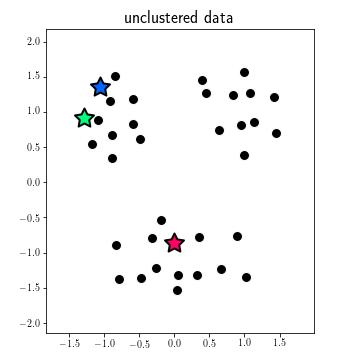
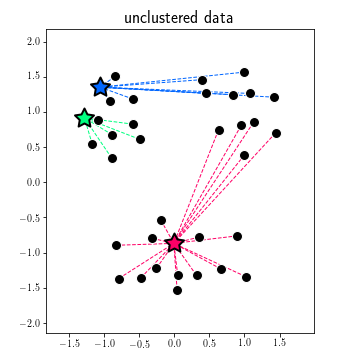
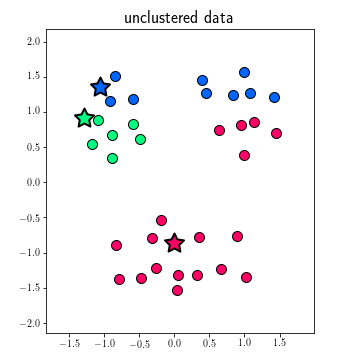
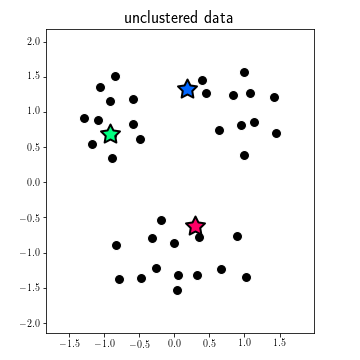
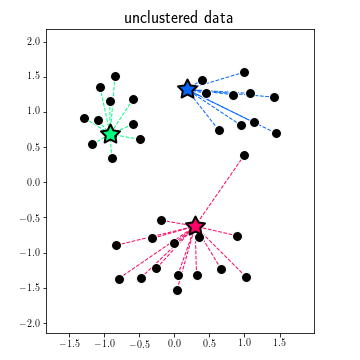
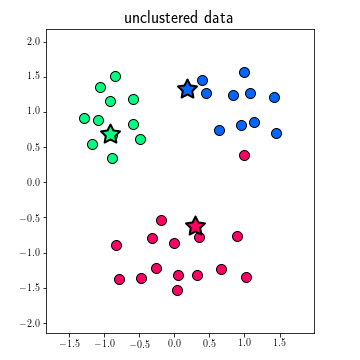
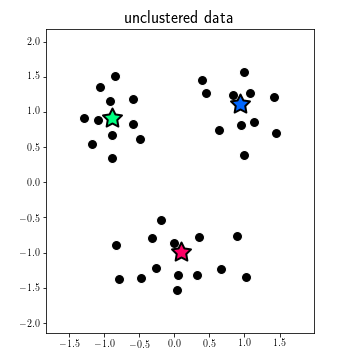
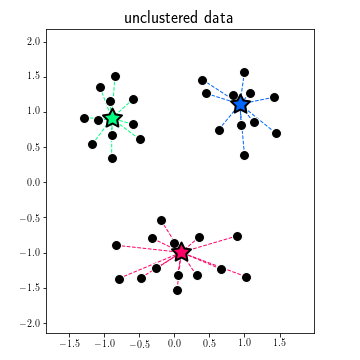
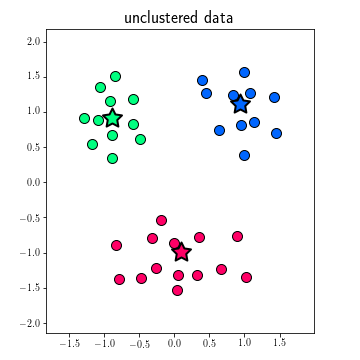
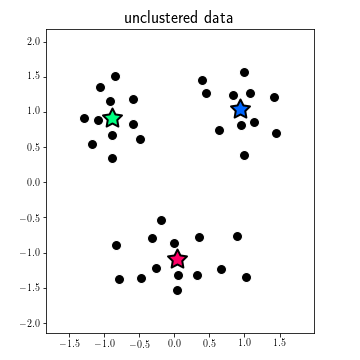
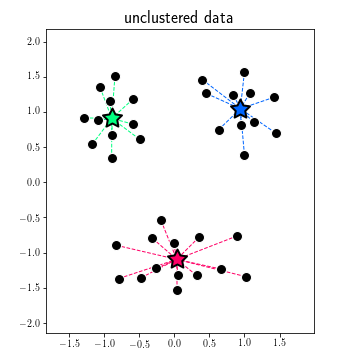
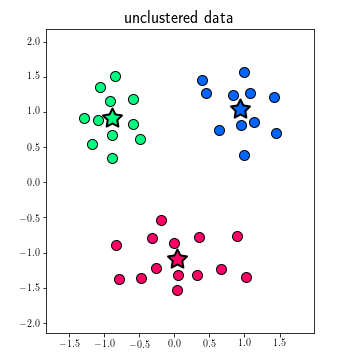

In [93]:
# initialize centroids as random points
r = np.arange(np.shape(data)[1])
num_clusters = 3
pts = np.random.permutation(r)[:num_clusters]
iniit_centroids = data[:,pts]

max_its = 3
unsuperlib.K_means_demos.run_animated_demo(data,iniit_centroids,max_its)

In [51]:
t = 5

2

In [78]:
d

1.0

#### <span style="color:#a50e3e;">Example 1: </span> K-means and bad local minima 

In this example using scikit-learn's [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) dataset, we illustrate how bad initialization of the K-means algorithm can lead to poor clustering results. The Python cell below creates and plots a dataset with $P=45$ data points and $K=3$ clusters along with specific centroid initializations stored in $\mathbf{C}$ and plotted using $\star$ symbols.  

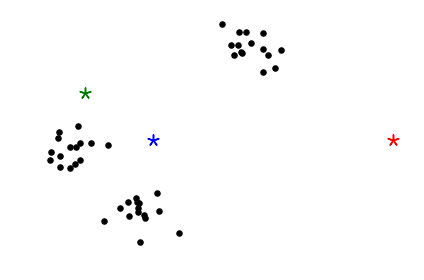

In [2]:
# create and load in data
blobs = datasets.make_blobs(n_samples=45, random_state=1)

# normalizing data so that all points fall within the unit square
# this is done for illustration purposes
X = unsuperlearnlib.K_means_methods.normalize_blobs(blobs)

# initialize centroids
C = np.array([[ 1,  .3,  .1],
              [.5,  .5,  .7]])

# plot data and initial centroids
unsuperlearnlib.K_means_methods.plot_data(X,C)

We now run K-means and animate centroid and assignment matrix updates at each iteration of the algorithm.

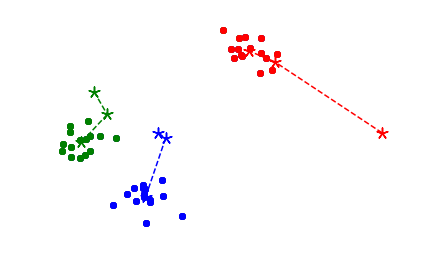

In [3]:
# run K-means
foo = unsuperlearnlib.K_means_methods.K_means_demo(X, C, mode='plot_the_steps')   

Everything worked well! Lets try a different centroid initialization this time.

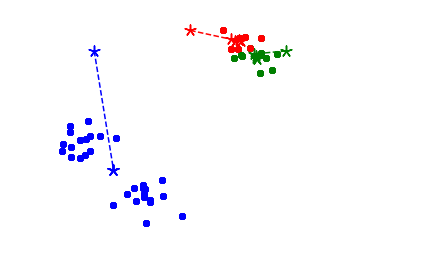

In [27]:
# a different centroid initialization
C = np.array([[ .4,  .1,  .7],
               [ 1,  .9,  .9]])

# run K-means
foo = unsuperlearnlib.K_means_methods.K_means_demo(X, C, mode='plot_the_steps')  

To avoid this issue, as with other non-convex problems, one should run K-means multiple times - each time initializing it differently - and pick the run that results in the lowest objective value.  

#### <span style="color:#a50e3e;">Example 2: </span> K-means and empty clusters

With random centroid initialization, it is possible for one or many of the clusters to end up empty, i.e., without any assigned data points, as you can see by activating the Python cell below.  

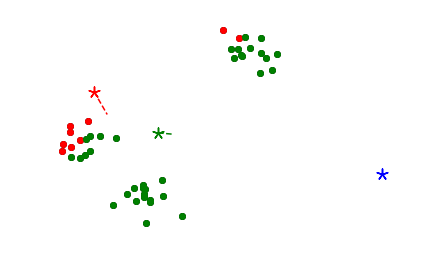

In [29]:
# centroid initialization
C = np.array([[ .1, 1, .3],
              [.7, .3, .5]])

# run K-means
foo = unsuperlearnlib.K_means_methods.K_means_demo(X, C, mode='plot_the_steps') 

Again, running K-means multiple times helps ameliorate this issue. Additionally, one can tweak the algorithm so that if one cluster ends up with no points, it is automatically assigned one of the points in the dataset at random. Alternatively one can initialize all cluster centroids in the beginning with actual data points selected at random from the dataset. 

## 1.4 The choice of K

As mentioned in the beginning of this post clustering is usually performed either to reduce the data dimension of large datasets, or to uncover underlying group structures in the data. In the former case, the choice of $K$ is determined by the size of the original dataset as well as the capacity of computational resources available at our disposal. In the latter case on the other hand, there is not much we can do without having knowledge/intuition about the correct number of clusters, but try different values for $K$ and compare the results. Unless in low dimensions, we cannot visually examine clustering results. Instead we can plot the objective value of K-means over a range of values for $K$, producing a so-called *scree plot*.  

#### <span style="color:#a50e3e;">Example 3: </span> Determining K using a scree plot

In the Python cell below we plot the K-means objective value for our blob dataset in the previous two Examples over $K=1,\ldots,10$.

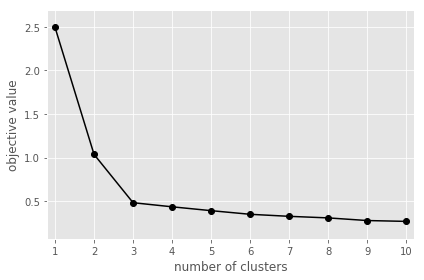

In [49]:
# scree plot
unsuperlearnlib.K_means_methods.scree_plot(X)

As one should expect, the objective value decreases monotonically as we increase $K$. Notice, the scree plot above has an *elbow* at $K=3$, meaning that increasing the number of clusters from $3$ to $4$ and onwards reduces the objective value by very little. Therefore one can argue - barring additional information about $K$  - that $K=3$ is a good choice for the number of clusters. 

<a id='endnotes'></a>
## References

[1] D’Haeseleer, P. How does gene expression clustering work? Nature Biotechnology. 23, 1499–1501, (2005).

[2] Eisen, M.B., Spellman, P.T., Brown, P.O. and Botstein, D. Cluster analysis and display of genome-wide expression patterns. Proc. Natl. Acad. Sci. USA 95, 14863–14868, (1998).